# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import warnings
import joblib
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error as sk_mape, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pmdarima as pm
from prophet import Prophet

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)

# Load Data

In [4]:
file_path = "Data/bazarya_price_data.csv"
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data = data.dropna(subset=['date'])

# Define Helper Functions

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def prepare_series(data, product, freq='W'):
    df = data[data['product'] == product].copy()
    df = df.set_index('date').sort_index()
    ts = df['price'].resample(freq).mean().interpolate(method='time')
    return ts.dropna()

def prophet_forecast(ts, h=12):
    if Prophet is None: return None
    df = ts.reset_index().rename(columns={'date': 'ds', 'price': 'y'})
    try:
        model = Prophet()
        model.fit(df)
        future = model.make_future_dataframe(periods=h, freq='W')
        forecast = model.predict(future)
        return forecast[['ds', 'yhat']].set_index('ds').iloc[-h:]['yhat']
    except Exception:
        return None

def create_ml_features(ts):
    df = ts.to_frame(name='y')
    for lag in [1, 2, 3, 4, 12]:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week.astype(int)
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    return df.dropna()

def ml_forecast(ts, h=12, product_name=None):
    df_feat = create_ml_features(ts)
    if len(df_feat) < h + 10:
        return None, None, None
    train = df_feat.iloc[:-h]
    test = df_feat.iloc[-h:]
    X_train, y_train = train.drop(columns=['y']), train['y']
    X_test, y_test = test.drop(columns=['y']), test['y']

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    model = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if product_name:
        joblib.dump(model.best_estimator_, f"{product_name}_rf_model.pkl")

    return y_pred, y_test.values, model.best_estimator_

# Run Forecasting for All Products

In [ ]:
products = data['product'].unique()
results = []

for product in products:
    ts = prepare_series(data, product)
    if len(ts) < 30:
        continue
    h = min(12, int(len(ts) * 0.2))
    test = ts[-h:]

    fc_prophet = prophet_forecast(ts, h=h)
    mape_prophet = mean_absolute_percentage_error(test, fc_prophet) if fc_prophet is not None else np.nan

    fc_ml, y_true_ml, model = ml_forecast(ts, h=h, product_name=product.replace(" ", "_"))
    mape_ml = mean_absolute_percentage_error(y_true_ml, fc_ml) if fc_ml is not None else np.nan
    rmse_ml = np.sqrt(mean_squared_error(y_true_ml, fc_ml)) if fc_ml is not None else np.nan
    r2_ml = r2_score(y_true_ml, fc_ml) if fc_ml is not None else np.nan

    try:
        model_arima = ARIMA(ts[:-h], order=(1,1,1)).fit()
        fc_arima = model_arima.forecast(steps=h)
        mape_arima = mean_absolute_percentage_error(test, fc_arima)
        rmse_arima = np.sqrt(mean_squared_error(test, fc_arima))
        r2_arima = r2_score(test, fc_arima)
        joblib.dump(model_arima, f"{product.replace(' ', '_')}_arima_model.pkl")
    except:
        mape_arima = rmse_arima = r2_arima = np.nan

    best = min([("ARIMA", mape_arima), ("Prophet", mape_prophet), ("ML", mape_ml)], key=lambda x: x[1] if pd.notna(x[1]) else np.inf)
    results.append({
        'product': product,
        'mape_arima': mape_arima,
        'rmse_arima': rmse_arima,
        'r2_arima': r2_arima,
        'mape_prophet': mape_prophet,
        'mape_ml': mape_ml,
        'rmse_ml': rmse_ml,
        'r2_ml': r2_ml,
        'best_method': best[0],
        'best_mape': best[1]
    })

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\rf4wmnme.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\6tand68p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=31148', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\rf4wmnme.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\6tand68p.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Millet_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\b3uu9fjz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\lpr_hchm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=78394', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\b3uu9fjz.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\lpr_hchm.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Hot_pepper_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\ol39hxki.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\gpx5ok75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=79488', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\ol39hxki.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\gpx5ok75.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Sugar_(local)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\bi59r_sz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\kzoadm3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=262', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\bi59r_sz.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\kzoadm3c.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\Tem

['Fava_beans_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\w31z0myl.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\7ubyoal_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=23513', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\w31z0myl.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\7ubyoal_.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Nifro_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\53vdg705.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\kafqk2eo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=38008', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\53vdg705.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\kafqk2eo.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Cabbage_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\9olxj2dw.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\ww59zd6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=18444', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\9olxj2dw.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\ww59zd6i.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Chicken_(dressed)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\3zcx_thr.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\pk12d8eu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=90520', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\3zcx_thr.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\pk12d8eu.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Beef_(raw)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\6vrqim50.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\hkxh02gh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=84952', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\6vrqim50.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\hkxh02gh.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Milk_(raw)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\diuyoc96.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\r1t3g78q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=43315', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\diuyoc96.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\r1t3g78q.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Onion_(red)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\hzx9nyqv.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\sjtk1wea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=13492', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\hzx9nyqv.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\sjtk1wea.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Green_pepper_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\s0kijtoj.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\0dmvkasy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=20469', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\s0kijtoj.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\0dmvkasy.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Barley_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\5muo_acj.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\szesxyhe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=97508', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\5muo_acj.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\szesxyhe.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Rice_(imported)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\pk35_2do.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\6a1jw9si.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=95497', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\pk35_2do.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\6a1jw9si.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Tea_(local)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\mu1r5ezt.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\hnso66ej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=7133', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\mu1r5ezt.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\hnso66ej.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\Te

['Cheese_(Ayib)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\8nyea9s6.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\x5ikt5w8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=82058', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\8nyea9s6.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\x5ikt5w8.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Maize_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\icbl27o8.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\heqp1g7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=70378', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\icbl27o8.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\heqp1g7e.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Butter_(traditional)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\1y58uuqz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\yfvlv2gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=98574', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\1y58uuqz.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\yfvlv2gd.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Lettuce_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\8aq953jt.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\ewta2f1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=84749', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\8aq953jt.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\ewta2f1m.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Beetroot_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\3u5sdr07.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\7u86k70c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=23611', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\3u5sdr07.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\7u86k70c.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Teff_(white)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\z2ydj65c.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\e7wddsrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=75528', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\z2ydj65c.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\e7wddsrb.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Papaya_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\yy3bq74y.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\elqs7nt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=330', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\yy3bq74y.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\elqs7nt7.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\Tem

['Cooking_oil_(palm)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\tqr5y2gh.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\k6wo6bsz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=45588', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\tqr5y2gh.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\k6wo6bsz.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Chicken_(live)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\x57uxsjz.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\5vp45yp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=76862', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\x57uxsjz.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\5vp45yp_.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Apple_(local)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\7dslg8ya.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\l049d7na.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=36334', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\7dslg8ya.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\l049d7na.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Banana_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\mkvk4mln.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\7_0d__1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=8313', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\mkvk4mln.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\7_0d__1w.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\Te

['Mango_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\d4qjwvno.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\vp9zh8oq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=33998', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\d4qjwvno.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\vp9zh8oq.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Shiro_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\jejzid1c.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\8or08361.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=80351', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\jejzid1c.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\8or08361.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Carrot_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\js833ad4.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\evprxdfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=23162', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\js833ad4.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\evprxdfl.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Yogurt_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\96tba2hl.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\mjgt0i1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=73313', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\96tba2hl.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\mjgt0i1t.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Lentils_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\4i88zi82.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\426vf5hw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=71660', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\4i88zi82.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\426vf5hw.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Spices_mix_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\wp80gg8_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\dr5xyu9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=39608', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\wp80gg8_.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\dr5xyu9r.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Orange_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\0w6g9ayc.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\mtonypp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=41559', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\0w6g9ayc.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\mtonypp_.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Lemon_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\obz2_3gf.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\1xxj93cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=83358', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\obz2_3gf.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\1xxj93cv.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Salt_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\y_j7arif.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\9yw1tqq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=68586', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\y_j7arif.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\9yw1tqq9.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Guava_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\dijbl2aq.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\o9eiwrou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=46115', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\dijbl2aq.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\o9eiwrou.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Eggs_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\zm8vzjmr.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\lgtdzxzo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=8283', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\zm8vzjmr.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\lgtdzxzo.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\Te

['Powdered_milk_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\s85i5f_y.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\agkuqe8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=24146', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\s85i5f_y.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\agkuqe8j.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Kale_(Gomen)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\df6klvpw.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\vy_rxn4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=12040', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\df6klvpw.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\vy_rxn4_.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Flour_(wheat)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\572j9ib7.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\p4s8a5p6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=29925', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\572j9ib7.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\p4s8a5p6.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Pepper_powder_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\uqxjg2ug.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\iui_pf2c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=47748', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\uqxjg2ug.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\iui_pf2c.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Wheat_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\knqjbg49.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\b7pf0ht1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=19007', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\knqjbg49.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\b7pf0ht1.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Teff_(red)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\vn301x4v.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\6nrn9_de.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=18032', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\vn301x4v.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\6nrn9_de.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Tomato_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\cv94ydg3.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\fdj1u122.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=16373', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\cv94ydg3.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\fdj1u122.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Coffee_(roasted)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\xw9z2hux.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\gavhr1ai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=36656', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\xw9z2hux.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\gavhr1ai.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Avocado_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\aup10534.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\gi5y6lha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=25831', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\aup10534.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\gi5y6lha.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Oats_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\yg1620dt.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\i10fypmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=40565', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\yg1620dt.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\i10fypmr.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Mutton_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\dmt83pz7.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\mdv0dni3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=30326', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\dmt83pz7.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\mdv0dni3.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Roasted_grains_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\9r8b9rn9.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\61qypje0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=61069', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\9r8b9rn9.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\61qypje0.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Potato_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\g13nbd0v.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\7ur5y2y2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=98810', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\g13nbd0v.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\7ur5y2y2.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Watermelon_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\5enm6hnw.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\78iag1a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=90459', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\5enm6hnw.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\78iag1a8.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Margarine_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\pqrkl69w.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\3hp3bk3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=52805', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\pqrkl69w.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\3hp3bk3r.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Spaghetti_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\q0c0vvd3.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\lypblp13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=27823', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\q0c0vvd3.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\lypblp13.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Macaroni_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\wy192zl_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\25melwch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=9915', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\wy192zl_.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\25melwch.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\Te

['Honey_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\jtqjvmdq.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\7b484h9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=4078', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\jtqjvmdq.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\7b484h9t.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\Te

['Rice_(local)_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\mvknffa8.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\f42vxf2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=64150', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\mvknffa8.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\f42vxf2b.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Chickpeas_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\iiqi3iws.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\8nuisxtk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=36617', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\iiqi3iws.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\8nuisxtk.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Goat_meat_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\x6175fqp.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\71jonnc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=53304', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\x6175fqp.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\71jonnc8.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Sorghum_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\fwp2h0c4.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\p5u9orvt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=40061', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\fwp2h0c4.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\p5u9orvt.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Dry_peas_arima_model.pkl']

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\q_sz_79h.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Ken\AppData\Local\Temp\tmpri48ruo1\0l8_hhu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Ken\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=10956', 'data', 'file=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\q_sz_79h.json', 'init=C:\\Users\\Ken\\AppData\\Local\\Temp\\tmpri48ruo1\\0l8_hhu5.json', 'output', 'file=C:\\Users\\Ken\\AppData\\Local\\T

['Grapes_arima_model.pkl']

# Display Results

In [7]:
results_df = pd.DataFrame(results).sort_values('best_mape')
print(results_df.head(10))

            product  mape_arima  rmse_arima  r2_arima  mape_prophet   mape_ml  \
7        Beef (raw)    2.674013   23.991653  0.000570      2.663627  2.311451   
11           Barley    2.808780   50.148891 -0.025512      2.734075  2.613978   
41       Teff (red)    3.984641   97.295522 -0.098889      3.697178  4.344827   
19     Teff (white)    4.024419   95.799970 -0.056244      3.903682  3.930039   
40            Wheat    4.798422   75.862997 -0.110071      4.748761  5.307510   
54     Rice (local)    5.340818  117.955094 -0.103795      5.324583  4.986144   
12  Rice (imported)    5.498617  145.448428 -0.052000      5.403969  5.296007   
8        Milk (raw)    5.800566    2.793997 -0.156807      5.318487  6.000607   
35             Eggs    5.912781    0.570343 -0.048390      5.932039  6.559185   
22   Chicken (live)    7.445052   34.649691 -0.071633      6.858599  6.556895   

       rmse_ml     r2_ml best_method  best_mape  
7    22.905108  0.089045          ML   2.311451  
11   45.

# Plot Forecast Example

<Figure size 1000x400 with 0 Axes>

Text(0.5, 1.0, 'Forecast for Beef (raw) (MAPE: 2.31%)')

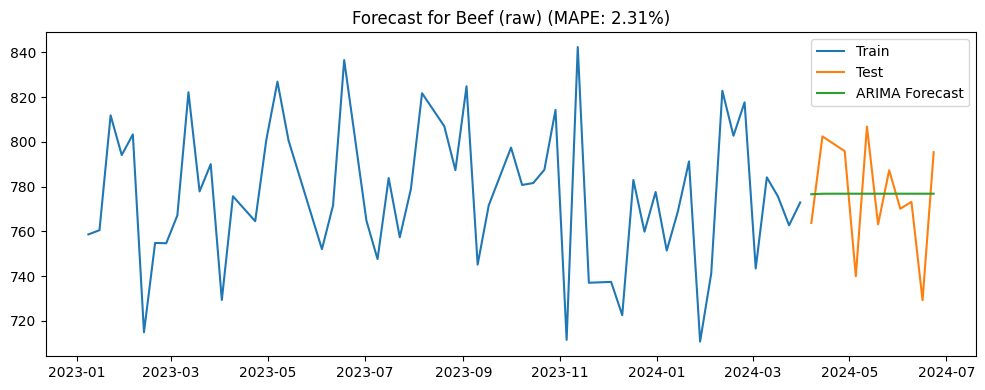

In [9]:
example = results_df.iloc[0]['product']
ts = prepare_series(data, example)
h = min(12, int(len(ts) * 0.2))
test = ts[-h:]
train = ts[:-h]
model = ARIMA(train, order=(1,1,1)).fit()
fc = model.forecast(steps=h)

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, fc, label='ARIMA Forecast')
plt.title(f"Forecast for {example} (MAPE: {results_df.iloc[0]['best_mape']:.2f}%)")
plt.legend()
plt.tight_layout()
plt.show()